In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lvm_to_h5 import *

In [5]:
def import_lvm_file(file_path):
    # Find the header row number
    header_row = -1
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if line.startswith('X_Value'):
                header_row = i
                break

    if header_row == -1:
        raise ValueError("Header row not found")

    # Read the LVM file using pandas read_csv function
    data = pd.read_csv(
        file_path,
        sep='\t',          # LVM files use tab as a delimiter
        comment='%',       # LVM files use % as a comment character
        skiprows=header_row,
        header=0,          # Use the header row found
        na_values=[''],    # Missing values are represented by empty strings
        engine='python',   # Use the Python parser (required for 'comment' parameter)
    )
    
    # Drop the last column (it's just NaNs because of the trailing tab)
    data = data.drop(data.columns[-1], axis=1)
    
    return data

## Importing Data

## Define Data Folders

In [50]:
# User Selection

Dropbox_drive = "F:/"
station_selected = "Station 3/"
NI_test_name = "st_1_test___002"


# Derived data paths
parent_data_folder = Dropbox_drive + "Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data"
NI_raw_data_folder = parent_data_folder + "/NI/Raw Data/"

NI_converted_data_folder = parent_data_folder + "/NI/Converted Data/"

full_raw_path = NI_raw_data_folder + station_selected + NI_test_name + ".lvm"
full_converted_path = NI_converted_data_folder + station_selected + NI_test_name + ".h5"

full_raw_path = "F:/Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data/Field Visit 1/Station 1/NI/st_1_test_2.lvm"

### Deprecated - Directly importing from .lvm

In [52]:
# Useful, but takes a long time to load each file.
# Around 4m 20s for 1.9GB file
data_frame = import_lvm_file(full_raw_path)


### Preferred: Importing hdf5 file

In [51]:
#convert_lvm_to_hdf5(full_raw_path, full_converted_path)
#full_converted_path = "F:/Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data/NI/Converted Data/Station 2/st_2_test___007.h5"
# Importing
data_frame = read_h5_to_dataframe(full_converted_path)

FileNotFoundError: ``F:\Dropbox\Projects\001 - CNRL - Pipewise\005 - Field Test\2023\data\NI\Converted Data\Station 3`` does not exist

## Header

In [53]:
print(data_frame.head())

    X_Value  D1 - Channel 0  D1 - Channel 1  D1 - Channel 2  D2 - Channel 0   
0  0.000000        0.036176        0.031144       -0.135890       -0.008778  \
1  0.000098        0.029803        0.022303       -0.232149       -0.044501   
2  0.000195       -0.003341        0.003674       -0.309603       -0.085008   
3  0.000293        0.005901        0.016304       -0.222906       -0.043863   
4  0.000391        0.028209        0.027039       -0.170633       -0.024088   

   D2 - Channel 1  D2 - Channel 2  D1 - Channel 3  D2 - Channel 3   
0       -0.000845        0.064145        0.000910       -1.267447  \
1        0.000103       -0.034675        0.000910       -1.611903   
2       -0.000529        0.033861        0.000277       -1.322749   
3        0.000103        0.000709        0.000277       -0.592755   
4       -0.000529        0.074664        0.000277        0.289559   

   D3 - Channel 0  D3 - Channel 1  D3 - Channel 2  D4 - Channel 0   
0       -0.130075        0.067274       -

## Meta Validation

### Data Points & Recording Time

In [54]:
# Access the first column using its index and count the number of data points
time_values = data_frame.iloc[:, 0]
data_points_count = time_values.count()

# Workaround to account for files that don't start at 0 seconds
initial_recording_time = time_values.iloc[0]
final_recording_time = time_values.iloc[-1]
delta_recording_time = final_recording_time - initial_recording_time

print("Number of data points in the first column:", data_points_count)
print("Data was recorded for", round(delta_recording_time,2), "seconds")
print("Data was recorded for", round(delta_recording_time/60,2), "minutes")
print("Data was recorded for", round(delta_recording_time/3600,2), "hours")

Number of data points in the first column: 11840000
Data was recorded for 1165.04 seconds
Data was recorded for 19.42 minutes
Data was recorded for 0.32 hours


### Sampling rate, Consistency and CV

In [55]:
# Calculate the time differences between consecutive data points
time_differences = time_values.diff().dropna()

# Define the expected sampling rate (in Hz) and maximum allowed deviation (in percentage)
expected_sampling_rate = 10000  # Replace with your expected sampling rate
max_allowed_deviation = 0.05  # 5% deviation, for example

# Calculate the expected time difference between consecutive data points
expected_time_difference = 1 / expected_sampling_rate

# Calculate the deviation of each time difference from the expected time difference
deviation = np.abs(time_differences - expected_time_difference)

# Count the number of time intervals that exceed the maximum allowed deviation
exceed_threshold_count = np.sum(deviation > max_allowed_deviation * expected_time_difference)

# Calculate the percentage of time intervals that exceed the maximum allowed deviation
exceed_threshold_percentage = exceed_threshold_count / len(time_differences) * 100

# Calculate the effective sampling rate
effective_sampling_rate = 1 / time_differences.mean()

print(f"Expected sampling rate: {expected_sampling_rate} Hz")
print(f"Effective sampling rate: {effective_sampling_rate:.2f} Hz")
print(f"Number of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_count}")
print(f"Percentage of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_percentage:.2f}%")


Expected sampling rate: 10000 Hz
Effective sampling rate: 10162.75 Hz
Number of time intervals exceeding 5.0% deviation: 5
Percentage of time intervals exceeding 5.0% deviation: 0.00%


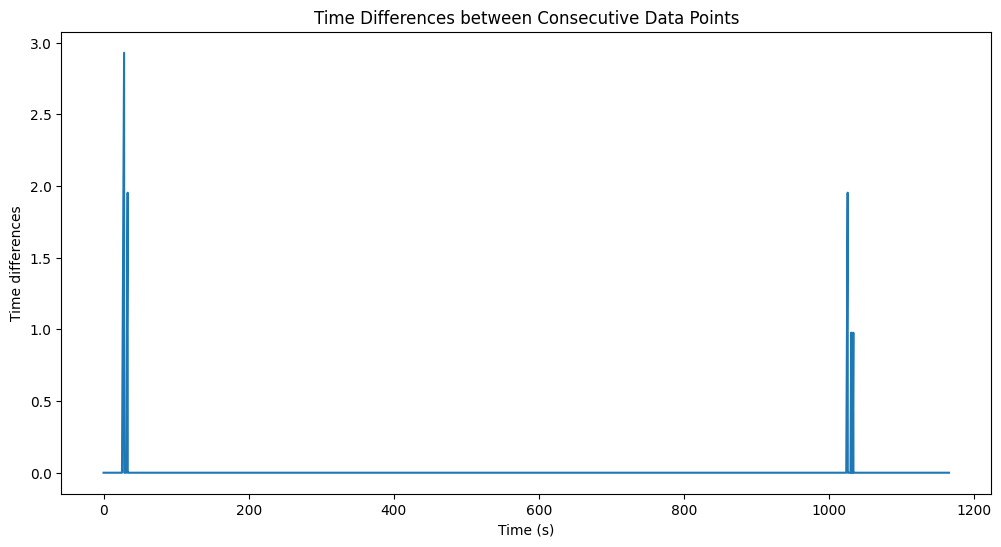

In [56]:
import matplotlib.pyplot as plt

# Remove the first value from time_values to match the length of time_differences
adjusted_time_values = time_values.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(adjusted_time_values, time_differences)
plt.xlabel("Time (s)")
plt.ylabel("Time differences")
plt.title("Time Differences between Consecutive Data Points")
plt.show()

### Disk Space Required

In [57]:
# Calculate the duration in seconds
start_time = data_frame.iloc[0, 0]
end_time = data_frame.iloc[-1, 0]
duration_seconds = end_time - start_time

# Get the file size in bytes
file_size_bytes = os.path.getsize(full_raw_path)

# Convert file size to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

# Calculate disk space per second in megabytes
disk_space_per_second_mb = file_size_mb / duration_seconds

print(f"Disk space per second: {round(disk_space_per_second_mb,2)} MB/s")

print(f"Disk space per minute: {round(disk_space_per_second_mb*60,2)} MB/min")

print(f"Disk space per hour: {round(disk_space_per_second_mb*60*60/1024,2)} GB/hour")

Disk space per second: 1.41 MB/s
Disk space per minute: 84.56 MB/min
Disk space per hour: 4.95 GB/hour


In [29]:
# Apply the condition to all channels except for the first one (time_values)
# If a value is greater than 5 or less than -5, set it to zero
#data_frame.iloc[:, 1:] = data_frame.iloc[:, 1:].applymap(lambda x: 0 if x > 5 or x < -5 else x)

## Signal

### Device 1

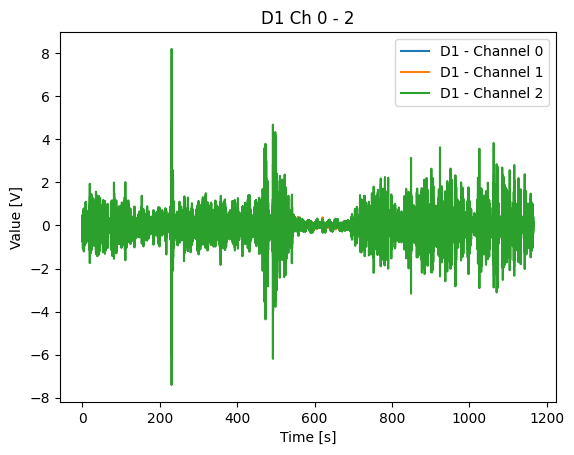

In [58]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D1 - Channel 0", "D1 - Channel 1", "D1 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((16550, 16550.1))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D1 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


### Device 2

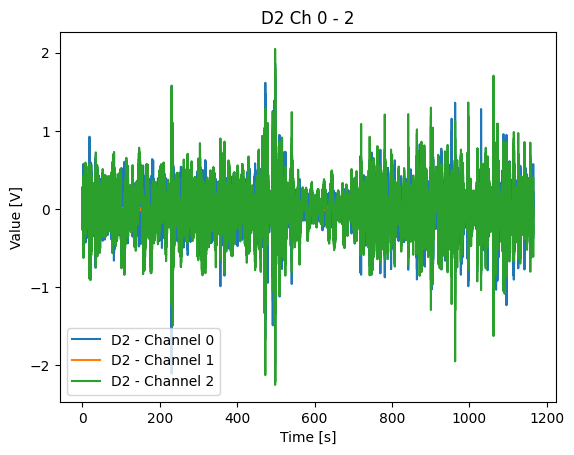

In [59]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D2 - Channel 0", "D2 - Channel 1", "D2 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((-10, 11))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D2 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


### IRIG-B

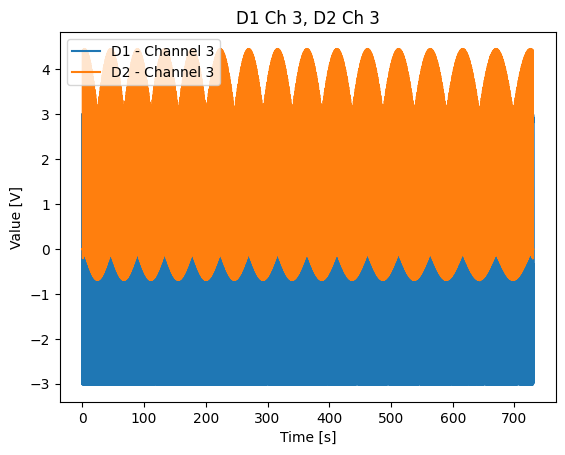

In [38]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D1 - Channel 3", "D2 - Channel 3"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((10, 11))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D1 Ch 3, D2 Ch 3')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


## Device 3

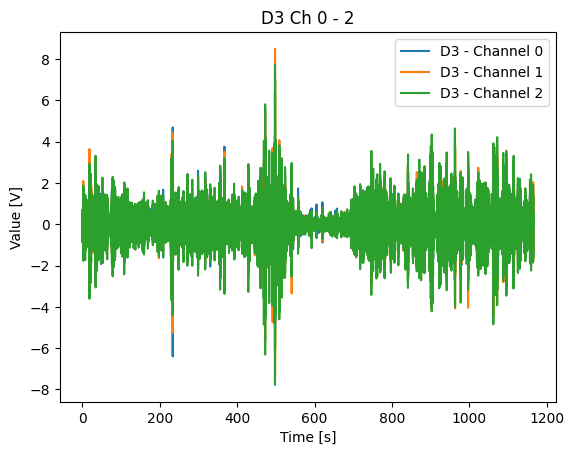

In [60]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D3 - Channel 0", "D3 - Channel 1", "D3 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((35, 40))
#plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D3 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


## Device 4

In [28]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D4 - Channel 0", "D4 - Channel 1", "D4 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

plt.xlim((45, 50))
plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D4 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()

KeyError: "None of [Index(['D4 - Channel 0', 'D4 - Channel 1', 'D4 - Channel 2'], dtype='object')] are in the [columns]"

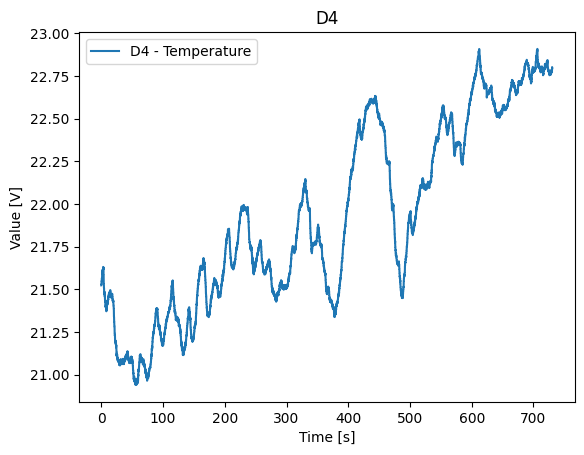

In [39]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D4 - Temperature"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((45, 50))
#plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D4')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()